# MA261 Modelling and Numerics: Assignment 3 Part 2

Student number: u2100098
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import array, exp, zeros, sqrt
from scipy.linalg import norm
from scipy.linalg import expm
from scipy.linalg import inv
from scipy.special import ellipj , ellipk

In [2]:
def forwardEuler(f, Df, t0, y0, h):
    # your code to compute y1
    y1=y0+h*f(t0,y0)
    return y1

def Q11(f,Df, t0,y0, h):
    y1=y0+(h/2)*(f(t0,y0)+f(t0+h,y0+h*f(t0,y0)))
    return y1

def evolve(phi, f,Df, t0,y0, T,N):
    # your code to compute y = numpy.array( [y0,...,yN]
    n= np.arange(0,N+1,1)
    h=(T-t0)/N
    tn=n*h
    Y=np.zeros((N+1,len(y0)))
    Y[0] = y0
    
    for i in range(N):
        Y[i+1]=phi(f, Df, tn[i],Y[i],h)

    return tn,Y

def computeEocs(herr):
    # your code to compute eocs
    m = np.size(herr,0)
    eocs = np.zeros(m-1)
    h=herr[:,0]
    e=herr[:,1]
    for i in range(m-1):
        eocs[i] = (np.log(e[i+1]/e[i])) / (np.log(h[i+1]/h[i]))
    return eocs

# Edited to take N0 as an additional parameter
def maxError(method,f,Df,Y,y0,T,N0,max_error):
    for i in range(np.shape(max_error)[0]):
        error = []
        N = N0 * (2**i)
        h = T/N
        t, y = evolve(method,f,Df,0,y0,T,N)

        for j in range(np.shape(y)[0]):
            error.append(np.linalg.norm(y[j]-Y(t[j])))

        error = np.array(error)
        max_error[i,:] = [h,np.max(error)]

    return max_error

def newton(F, DF, x0, epsilon, K):
    x = x0
    k = 0
    while k < K:
        delta = np.linalg.solve(DF(x), -F(x))
        x = x + delta
        k += 1
        if np.linalg.norm(F(x)) < epsilon:
            break
    return x, k

def backwardEuler(f, Df, t0, y0, h):
    F = lambda delta: delta - f(t0+h,y0+h*delta)
    DF = lambda delta: np.eye(len(y0))-h*Df(t0+h,y0+h*delta)
    x,k=newton(F,DF,f(t0+h,y0),h*h*1e-5,1000)
    return y0+h*x

def crankNicholson(f, Df, t0, y0, h):
    F = lambda x: x - 1/2*(f(t0,y0)+f(t0+h,y0+h*x))
    DF = lambda x: np.eye(len(y0)) - (1/2)*h*Df(t0+h,y0+h*x)
    x,k = newton(F,DF,f(t0+h,y0),h**2*1e-5,1000)
    return y0+h*x

def ham(t,y):
    return 0.5*y[1]**2 - omega0**2 * np.cos(y[0])

---
### Q 2.0. Quiz Work


In [3]:
def dirk(f,Df, t0,y0, h, alpha,beta,gamma):
    m = len(alpha)
    n = len(y0)
    k = [np.zeros_like(y0) for _ in range(len(alpha))]
    for i in range(len(alpha)):
        yplus = 0
        for j in range(i):
            yplus = yplus + beta[i,j]*k[j]
        F = lambda x: x - f(t0 + alpha[i]*h,y0 + h*yplus + h*beta[i,i]*x)
        DF = lambda x: np.eye(n) - h*beta[i,i]*Df(t0 + alpha[i]*h, y0 + h*yplus + h*beta[i,i]*x)
        x,_ = newton(F, DF, f(t0, y0), 1e-15, 1000)
        k[i] = x

    y = y0
    for i in range(m):
        y = y + h*gamma[i]*k[i]
    
    return y

In [4]:
def taylor(f,Df,dtdf, t0,y0, h):
    return y0+h*f(t0,y0)+0.5*(h**2)*Df(t0,y0).dot(f(t0,y0)) +0.5*(h**2)*dtdf(t0,y0)

---
### Q 2.1. DIRK Testing

,h,d=0 max error,d=0 eocs,d=1/4 max error,d=1/4 eocs,d=1/2 + sqrt(3)/6 max error,d=1/2 + sqrt(3)/6 eocs
0,4.000000e-01,2.336009e-01,0.000000e+00,1.980478e-02,0.000000e+00,4.445094e-02,0.000000e+00
1,2.000000e-01,5.724377e-02,2.028855e+00,5.230983e-03,1.920695e+00,8.023322e-03,2.469943e+00
2,1.000000e-01,1.252991e-02,2.191742e+00,1.295326e-03,2.013767e+00,1.206824e-03,2.732984e+00
3,5.000000e-02,2.894328e-03,2.114076e+00,3.279166e-04,1.981914e+00,1.694120e-04,2.832608e+00
4,2.500000e-02,6.889803e-04,2.070694e+00,8.193583e-05,2.000763e+00,2.265019e-05,2.902941e+00
5,1.250000e-02,1.680073e-04,2.035939e+00,2.048125e-05,2.000191e+00,2.928069e-06,2.951502e+00
6,6.250000e-03,4.148271e-05,2.017942e+00,5.120459e-06,1.999959e+00,3.724442e-07,2.974853e+00
7,3.125000e-03,1.030578e-05,2.009056e+00,1.280139e-06,1.999973e+00,4.696281e-08,2.987434e+00
8,1.562500e-03,2.568356e-06,2.004537e+00,3.200344e-07,2.000001e+00,5.896118e-09,2.993681e+00
9,7.812500e-04,6.410798e-07,2.002270e+00,8.000881e-08,1.999996e+00,7.386347e-10,2.996832e+00


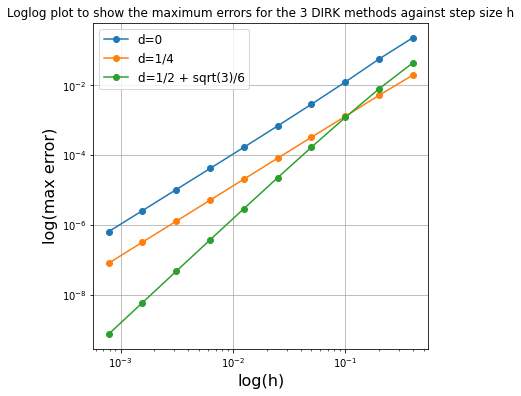

In [5]:
Y = lambda t: np.array([ 2*np.exp(t) / (2*np.exp(t) - 1), -2*np.exp(t) / (4*np.exp(2*t) - 4*np.exp(t) + 1) ])
f = lambda t,y: np.array([y[1],y[1]*(1-2*y[0])])
Df = lambda t,y: np.array([[0,1],[-2*y[1],1-2*y[0]]])

T=10
y0 = np.array([2,-2])
max_error1 = np.zeros((10,2))

alpha = lambda d: np.array([d,1-d])
beta = lambda d: np.array([[d,0],[1-2*d,d]])
gamma = np.array([0.5,0.5])

dirk1 = lambda f, Df, t0, y0, h: dirk(f,Df,t0,y0,h,alpha(0),beta(0),gamma)
dirk2 = lambda f, Df, t0, y0, h: dirk(f,Df,t0,y0,h,alpha(0.25),beta(0.25),gamma)
dirk3 = lambda f, Df, t0, y0, h: dirk(f,Df,t0,y0,h,alpha(0.5+np.sqrt(3)/6),beta(0.5+np.sqrt(3)/6),gamma)

max_error1 = np.zeros((10,2))
max_error1 = maxError(dirk1,f,Df,Y,y0,T,25,max_error1)

max_error2 = np.zeros((10,2))
max_error2 = maxError(dirk2,f,Df,Y,y0,T,25,max_error2)

max_error3 = np.zeros((10,2))
max_error3 = maxError(dirk3,f,Df,Y,y0,T,25,max_error3)

errorData = np.column_stack((max_error1[:, 0],max_error1[:, 1],np.insert(computeEocs(max_error1),0,0),max_error2[:, 1],np.insert(computeEocs(max_error2),0,0),max_error3[:, 1],np.insert(computeEocs(max_error3),0,0)))
errorDF = pd.DataFrame(errorData,columns =['h','d=0 max error','d=0 eocs','d=1/4 max error','d=1/4 eocs','d=1/2 + sqrt(3)/6 max error','d=1/2 + sqrt(3)/6 eocs']).style.format("{:.6e}")
errorDF.set_caption('Table to show the maximum errors and experimental orders of convergence for the 3 dirk methods for each value of h').set_table_styles([{
    'selector': 'caption',
    'props': [('font-size', '20px')]
}])
display(errorDF)

plt.figure(figsize=(6,6))
plt.title('Loglog plot to show the maximum errors for the 3 DIRK methods against step size h')
plt.xlabel('log(h)', fontsize=16)
plt.ylabel('log(max error)', fontsize=16)
plt.loglog(max_error1[:, 0],max_error1[:, 1],label = 'd=0',marker='o')
plt.loglog(max_error2[:, 0],max_error2[:, 1],label = 'd=1/4',marker='o')
plt.loglog(max_error3[:, 0],max_error3[:, 1],label = 'd=1/2 + sqrt(3)/6',marker='o')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In terms of d, the first 3 order conditions are:

$$ \sum_{i=1}^{m} \gamma_{i} = \frac{1}{2} + \frac{1}{2} = 1 $$
$$ \sum_{i=1}^{m} \alpha_{i}\gamma_{i} = \frac{1}{2}d + \frac{1}{2}(1-d) = \frac{1}{2} $$
$$ \sum_{i=1}^{m} \alpha_{i}^2\gamma_{i} = \frac{1}{2}d^2 + \frac{1}{2}(1-d)^2 = d^2 -d +\frac{1}{2} $$

So we know that for all 3 methods, the order of consistency p >= 2.

Now when d=0, the third sum is equal to 1/2 which is not 1/3, so the first method has order of consistency 2.

When d = 1/4, the third sum is equal to 5/16 which is not 1/3, so the second method has order of consistency 2.

When d = 1/2 + sqrt(3)/6, the third sum is equal to 1/3, so the third method has order of consistency p >=3.

The experimental orders of convergence are 2, 2, and 3 respectively. If a method is consistent of order p, it converges with order p, so the orders of consistency from the numerical results are 2, 2, and 3. The first 2 match up with our theory perfectly, with the methods having order of consisteand the third method fits in well as well, 

The sequences of experimental orders of convergence tend to 2, 2, and 3 respectively.

If a method is consistent of order p, it converges with order p, so the orders of consistency from the numerical results are 2, 2, and 3.

This matches with our theory. Our theory states that the first 2 methods have orders of consistency 2, which our numerical results agree with. Our numerical results tell us that the third method has order of consistency 3, which ties in with the weaker claim that out theory states, i.e p>=3.

---
### Q 2.2. Implicit DIRK methods

,h,d=1/4 max error,d=1/4 eocs,d=1/2 + sqrt(3)/6 max error,d=1/2 + sqrt(3)/6 eocs
0,2.000000e-01,1.251875e+00,0.000000e+00,6.537392e-01,0.000000e+00
1,1.000000e-01,7.578249e-01,7.241535e-01,5.406771e-01,2.739481e-01
2,5.000000e-02,2.055128e-01,1.882637e+00,1.549727e-01,1.802754e+00
3,2.500000e-02,5.162042e-02,1.993214e+00,2.411841e-02,2.683807e+00
4,1.250000e-02,1.292104e-02,1.998220e+00,3.176289e-03,2.924720e+00
5,6.250000e-03,3.230648e-03,1.999826e+00,4.037486e-04,2.975813e+00
6,3.125000e-03,8.076770e-04,1.999973e+00,5.081873e-05,2.990025e+00


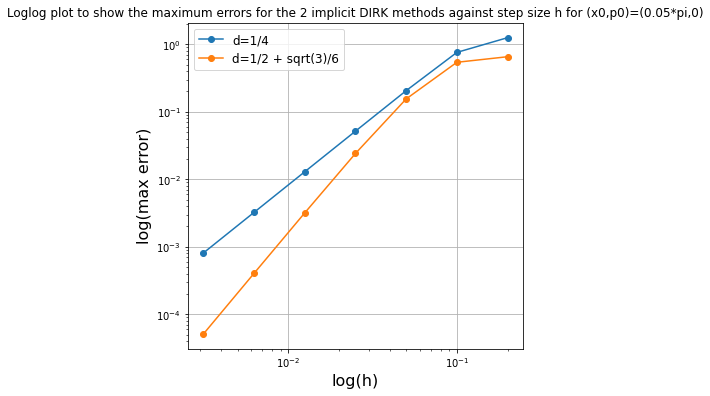

,h,d=1/4 max error,d=1/4 eocs,d=1/2 + sqrt(3)/6 max error,d=1/2 + sqrt(3)/6 eocs
0,2.000000e-01,2.601630e+00,0.000000e+00,1.004820e+01,0.000000e+00
1,1.000000e-01,6.420973e-01,2.018552e+00,1.177285e+01,-2.285268e-01
2,5.000000e-02,1.607761e-01,1.997739e+00,1.256500e+01,-9.394677e-02
3,2.500000e-02,4.011672e-02,2.002778e+00,9.939796e+00,3.381224e-01
4,1.250000e-02,1.002939e-02,1.999970e+00,1.349607e+00,2.880677e+00
5,6.250000e-03,2.507098e-03,2.000144e+00,1.702809e-01,2.986551e+00
6,3.125000e-03,6.267770e-04,1.999994e+00,2.130899e-02,2.998382e+00


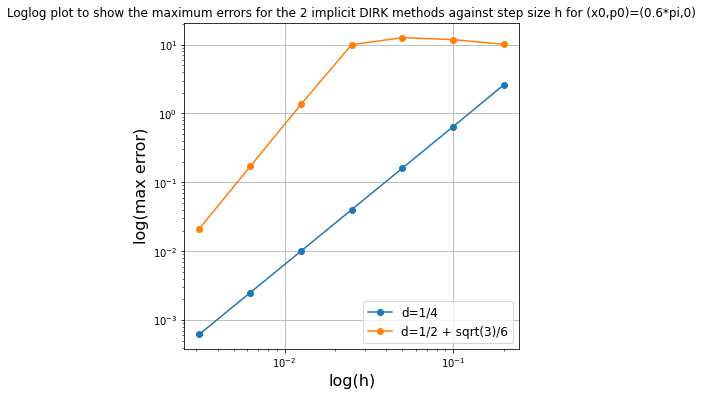

In [6]:
omega0 = 4
x0 = 0.05*np.pi
p0 = 0
y0=np.array([x0,p0])
N0 = 500
I = 7
T = 100
t0 =0

f = lambda t,y: np.array([y[1],-omega0**2 *np.sin(y[0])])
Df = lambda t,y: np.array([[0,1],[-omega0**2 *np.cos(y[0]),0]])

k = np.sin(x0 /2) # x0: initial condition
K = ellipk(k*k)

def Y2(t):
    sn , cn , dn , _ = ellipj(K- omega0 *t, k*k)
    x = 2* np.arcsin (k*sn)
    p = 2/np.sqrt(1 -(k*sn)**2) * cn*dn * k*(-omega0)
    return np.array([x,p])

max_error4 = np.zeros((I,2))
max_error4 = maxError(dirk2,f,Df,Y2,y0,T,N0,max_error4)

max_error5 = np.zeros((I,2))
max_error5 = maxError(dirk3,f,Df,Y2,y0,T,N0,max_error5)

errorData2 = np.column_stack((max_error4[:, 0],max_error4[:, 1],np.insert(computeEocs(max_error4),0,0),max_error5[:, 1],np.insert(computeEocs(max_error5),0,0)))
errorDF2 = pd.DataFrame(errorData2,columns =['h','d=1/4 max error','d=1/4 eocs','d=1/2 + sqrt(3)/6 max error','d=1/2 + sqrt(3)/6 eocs']).style.format("{:.6e}")
errorDF2.set_caption('Table to show the maximum errors and experimental orders of convergence for the 2 implicit dirk methods for (x0,p0)=(0.05*pi,0)').set_table_styles([{
    'selector': 'caption',
    'props': [('font-size', '20px')]
}])
display(errorDF2)

plt.figure(figsize=(6,6))
plt.title('Loglog plot to show the maximum errors for the 2 implicit DIRK methods against step size h for (x0,p0)=(0.05*pi,0)')
plt.xlabel('log(h)', fontsize=16)
plt.ylabel('log(max error)', fontsize=16)
plt.loglog(max_error4[:, 0],max_error4[:, 1],label = 'd=1/4',marker='o')
plt.loglog(max_error5[:, 0],max_error5[:, 1],label = 'd=1/2 + sqrt(3)/6',marker='o')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

x0 = 0.6*np.pi
p0 = 0
y0=np.array([x0,p0])

k = np.sin(x0 /2) # x0: initial condition
K = ellipk(k*k)

def Y3(t):
    sn , cn , dn , _ = ellipj(K- omega0 *t, k*k)
    x = 2* np.arcsin (k*sn)
    p = 2/np.sqrt(1 -(k*sn)**2) * cn*dn * k*(-omega0)
    return np.array([x,p])

max_error6 = np.zeros((I,2))
max_error6 = maxError(dirk2,f,Df,Y3,y0,T,N0,max_error6)

max_error7 = np.zeros((I,2))
max_error7 = maxError(dirk3,f,Df,Y3,y0,T,N0,max_error7)

# print(max_error6)
# print(max_error7)

errorData3 = np.column_stack((max_error6[:, 0],max_error6[:, 1],np.insert(computeEocs(max_error6),0,0),max_error7[:, 1],np.insert(computeEocs(max_error7),0,0)))
errorDF3 = pd.DataFrame(errorData3,columns =['h','d=1/4 max error','d=1/4 eocs','d=1/2 + sqrt(3)/6 max error','d=1/2 + sqrt(3)/6 eocs']).style.format("{:.6e}")
errorDF3.set_caption('Table to show the maximum errors and experimental orders of convergence for the 2 implicit dirk methods for (x0,p0)=(0.6*pi,0)').set_table_styles([{
    'selector': 'caption',
    'props': [('font-size', '20px')]
}])
display(errorDF3)

plt.figure(figsize=(6,6))
plt.title('Loglog plot to show the maximum errors for the 2 implicit DIRK methods against step size h for (x0,p0)=(0.6*pi,0)')
plt.xlabel('log(h)', fontsize=16)
plt.ylabel('log(max error)', fontsize=16)
plt.loglog(max_error6[:, 0],max_error6[:, 1],label = 'd=1/4',marker='o')
plt.loglog(max_error7[:, 0],max_error7[:, 1],label = 'd=1/2 + sqrt(3)/6',marker='o')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Here we can see that the EOCs converge to 2 and 3 for both initial conditions, as before, which also agrees with our theory from above.

The method with d = 1/2 + sqrt(3)/6 has errors that converge to 0 faster with the first initial condition.

Note also that the method with d = 1/2 + sqrt(3)/6 has a greater maximum error at all step sizes for the second initial condition. 

The method with d = 1/2 + sqrt(3)/6 for the second initial condition plateaus eventually, whereas for the d = 1/4 method the log log relationship is linear throughout.

In [7]:
a=evolve(dirk2,f,Df,t0,y0,T,N0*2**1)[1][-1]
hama = 0.5*a[1]**2 - omega0**2 *np.cos(a[0])
print(hama)

b=evolve(dirk2,f,Df,t0,y0,T,N0*2**3)[1][-1]
hamb = 0.5*b[1]**2 - omega0**2 *np.cos(b[0])
print(hamb)

c=evolve(dirk3,f,Df,t0,y0,T,N0*2**1)[1][-1]
hamc = 0.5*c[1]**2 - omega0**2 *np.cos(c[0])
print(hamc)

d=evolve(dirk3,f,Df,t0,y0,T,N0*2**3)[1][-1]
hamd = 0.5*d[1]**2 - omega0**2 *np.cos(d[0])
print(hamd)

hamy0 = 0.5*y0[1]**2 - omega0**2 *np.cos(y0[0])
print(hamy0)

4.957249638867275
4.9455152336283525
-14.900571206849396
4.272103953704235
4.944271909999157


Here the first 2 values are the Hamiltonian for i=1 and i=3 for d=1/4. The 3rd and 4th values are the Hamiltonian for i=1 and i=3 for d=1/2+ sqrt(3)/6. The 5th value is the value of the Hamiltonian at y0.

We can see that for d=1/4, the Hamiltonian is conserved well for both i=1 and i=3, but the Hamiltonian is closer to H(y0) for i=3. This is in line with our theory.

For d = 1/2+ sqrt(3)/6 we see that for i=1 the Hamiltonian is far away from H(y0). This could be due to the method not being stable for this value of Ni. For i=3 the Hamiltonian is close to H(y0) but not as close as our values for d=1/4. This further supports the idea that this method is unstable for these values of Ni.

---
### Q 2.3. Exponentially Fit DIRK

Here I change the implementation; I will use the code from the exemplar assignment solutions.

In [8]:
def Hamiltonian(y):
    return np.array([0.5*y[1]**2-omega0**2 *np.cos(y[0])])

def experiment(stepper):
    herr = zeros( [M,2] )
    for m in range(M):
        N = N0*2**m
        t,y = evolve( stepper, f,Df, 0,Y(0),T, N)
        herr[m] = [T/N, 0]
        for tn,yn in zip(t,y):
            herr[m][1] = max(herr[m][1], norm(yn-Y(tn)))

    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )

    return res

def experimentHamiltonian(stepper):
    herr = zeros( [M,2] )
    for m in range(M):
        N = N0*2**m
        k = T/N
        herr[m] = [k, 0]
        t,y = evolve( stepper, f,Df, 0,Y(0),T, N)
        for tn,yn in zip(t,y):
            herr[m][1] = max(herr[m][1], abs(Hamiltonian(yn) - Hamiltonian(Y(0)))/abs(Hamiltonian(Y(0))))

    res = np.hstack( [herr] )

    return res

def compareErrors(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n}-error', f'{n}-eoc']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[2*i+1]]   = results[k][:,1] # errors
        styles[columns[2*i+1]] = '{:.6e}'
        keys[columns[2*i+2]]   = results[k][:,2] # eocs
        styles[columns[2*i+2]] = '{:.3f}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for a,b in enumerate(simul):
        plt.loglog(results[b][:,0],results[b][:,1],marker='o',label=b)
    plt.grid(True)
    plt.legend()
    plt.xlabel("step size")
    plt.ylabel("Maximum error")
    plt.title("Log-log Plot for Maximum error vs StepSize")
    plt.show()
    
def ButcherTableau(d):
    alphabt = np.array([d, 1-d])
    betabt = np.array([[d, 0.], [1-(2.*d), d]])
    gammabt = np.array([0.5, 0.5])
    return alphabt, betabt, gammabt

def compareErrorsHam(results):
    simul = list(results.keys())
    columns=['h'] + [f'{n}-relative error' for n in simul]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[i+1]]   = results[k][:,1] # errors
        styles[columns[i+1]] = '{:.6e}'
        #keys[columns[2*i+2]]   = results[k][:,2] # eocs
        #styles[columns[2*i+2]] = '{:.3f}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    plt.xlabel("step size")
    plt.ylabel("Maximum relative error")
    plt.title("Log-log plot for Maximum relative error")
    plt.show()

def initialExp(Minitial,T,N,alpha):
    h=T/N
    exphM = expm(Minitial*h)
    exphMs = []
    exphMsInv = []
    for i in alpha:
        mat = expm(h*i*Minitial)
        exphMs.append(mat)
        exphMsInv.append(expm(-h*i*Minitial))
    return exphMs, exphMsInv, exphM

def edirk(f,Df,t0,y0,h,alpha,beta,gamma,exphMs,exphMsInv,exphM):
    m = len(alpha)
    n = len(y0)
    k = np.zeros((m,n))
    y = y0
    for i in range(m):
        yplus = 0
        for j in range(i):
            yplus = yplus + beta[i,j]*k[j]
        F = lambda x: x - exphMsInv[i].dot(f(t0+alpha[i]*h,exphMs[i].dot(y0+h*(yplus+beta[i][i]*x))))
        DF = lambda x: np.eye(n) - h*beta[i,i]*Df(t0 + alpha[i]*h, exphMs[i].dot(y0+h*(yplus+beta[i][i]*x)))
        
        x,_ = newton(F, DF, f(t0, y0), 1e-15, 1000)
        k[i] = x
    
    y = y0
    for i in range(m):
        y = y + h*gamma[i]*k[i]

    return exphM.dot(y)

def expexperiment(d):
    N0 = 500
    T = 100
    alpha, beta, gamma = ButcherTableau(d)
    herr = np.zeros([M, 2])
    for m in range(M):
        N = N0 * 2**m
        
        stepper = lambda f , Df , t0 , y0 , h : (
        edirk ( lambda t , y : f (t , y ) - Minitial . dot ( y ) ,
        lambda t , y : Df (t , y ) - Minitial , t0 , y0 ,h ,
        alpha , beta , gamma ,
        *initialExp(Minitial, T, N, alpha)
        ))
        
        t, y = evolve(stepper, f, Df, 0, Y(0), T, N)
        
        herr[m] = [T/N, 0]
        for tn,yn in zip(t,y):
            herr[m][1] = max(herr[m][1], norm(yn-Y(tn)))
            
    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )
    
    return res

def expexperimentHamiltonian(d):
    T = 100
    N0 = 500
    alpha, beta, gamma = ButcherTableau(d)
    herr = np.zeros([M, 2])
    for m in range(M):
        N = N0 * 2**m
        
        stepper = lambda f , Df , t0 , y0 , h : (
        edirk ( lambda t , y : f (t , y ) - Minitial . dot ( y ) ,
        lambda t , y : Df (t , y ) -Minitial , t0 , y0 ,h ,
        alpha , beta , gamma ,
        *initialExp(Minitial, T, N, alpha)
        ))
        
        t, y = evolve(stepper, f, Df, 0, Y(0), T, N)
        
        herr[m] = [T/N, 0]
        for tn,yn in zip(t,y):
            herr[m][1] = max(herr[m][1], abs(Hamiltonian(yn) - Hamiltonian(Y(0)))/abs(Hamiltonian(Y(0))))
            
    res = np.hstack( [herr] )
    
    return res

In [9]:
omega0 = 4
x0=y0[0]
p0=y0[1]

Minitial = np.array([[0., 1], [-omega0**2, 0.]])
M = 8

k = np.sin(0.05*np.pi/2) # x0 : initial condition
K = ellipk(k*k)

def Y(t):
    sn , cn , dn , _ = ellipj(K- omega0 *t, k*k)
    x = 2* np.arcsin (k*sn)
    p = 2/np.sqrt(1 -(k*sn)**2) * cn*dn * k*(-omega0)
    return np.array([x,p])

DIRK1 = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,*ButcherTableau(0.25))
res_dirk1 = experiment(DIRK1)
DIRK2 = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,*ButcherTableau(0.5 + np.sqrt(3)/6.))
res_dirk2 = experiment(DIRK2)

res_edirk1 = expexperiment(0.25)
res_edirk2 = expexperiment(0.5 + np.sqrt(3)/6.)

,h,d = 1/4 edirk-error,d = 1/4 edirk-eoc,d = 1/2 + sqrt(3)/6 edirk-error,d = 1/2 + sqrt(3)/6 edirk-eoc
0,2.0000e-01,9.485811e-05,nan,2.023538e-04,nan
1,1.0000e-01,2.315994e-05,2.034,2.970418e-05,2.768
2,5.0000e-02,5.757000e-06,2.008,3.926161e-06,2.919
3,2.5000e-02,1.444690e-06,1.995,4.965794e-07,2.983
4,1.2500e-02,3.610426e-07,2.001,6.228502e-08,2.995
5,6.2500e-03,9.030932e-08,1.999,7.795787e-09,2.998
6,3.1250e-03,2.257688e-08,2.000,9.747916e-10,3.000
7,1.5625e-03,5.641530e-09,2.001,1.250225e-10,2.963


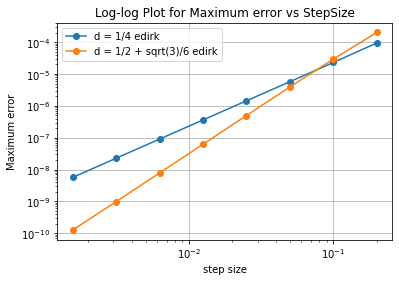

In [10]:
compareErrors({"d = 1/4 edirk":res_edirk1, "d = 1/2 + sqrt(3)/6 edirk":res_edirk2})

The EOCs converge to 2 and 3 as before. Notice that the edirk errors tend to 0 much faster than the dirk methods in 2.2.

,h,d = 1/4 dirk-relative error,d = 1/2 + sqrt(3)/6 dirk-relative error
0,2.0000e-01,9.840171e-07,1.246513e-02
1,1.0000e-01,2.532626e-07,1.218718e-02
2,5.0000e-02,6.378604e-08,5.231871e-03
3,2.5000e-02,1.597617e-08,8.481509e-04
4,1.2500e-02,3.995901e-09,1.103054e-04
5,6.2500e-03,9.990915e-10,1.387365e-05
6,3.1250e-03,2.497805e-10,1.736054e-06
7,1.5625e-03,6.244581e-11,2.170514e-07


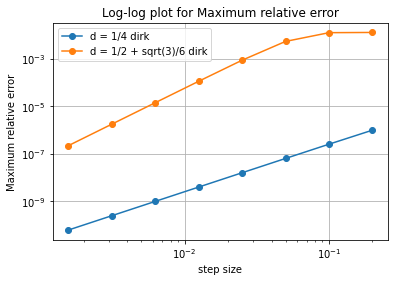

,h,d = 1/4 edirk-relative error,d = 1/2 + sqrt(3)/6 edirk-relative error
0,2.0000e-01,1.121164e-06,7.158414e-06
1,1.0000e-01,2.690749e-07,1.037138e-06
2,5.0000e-02,6.660893e-08,1.344941e-07
3,2.5000e-02,1.661160e-08,1.695804e-08
4,1.2500e-02,4.150367e-09,2.123731e-09
5,6.2500e-03,1.037438e-09,2.655427e-10
6,3.1250e-03,2.593509e-10,3.319018e-11
7,1.5625e-03,6.483613e-11,4.254463e-12


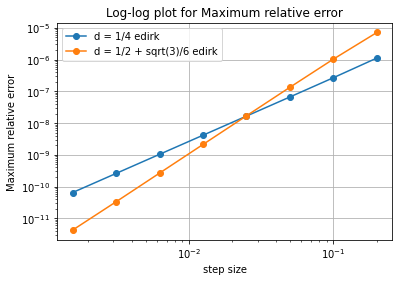

In [11]:
DIRK1_Ham = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,*ButcherTableau(0.25))
res_dirk1_Ham = experimentHamiltonian(DIRK1_Ham)
DIRK2_Ham = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,*ButcherTableau(0.5 + np.sqrt(3)/6.))
res_dirk2_Ham = experimentHamiltonian(DIRK2_Ham)

res_edirk1_Ham = expexperimentHamiltonian(0.25)
res_edirk2_Ham = expexperimentHamiltonian(0.5 + np.sqrt(3)/6.)

compareErrorsHam({"d = 1/4 dirk":res_dirk1_Ham, "d = 1/2 + sqrt(3)/6 dirk":res_dirk2_Ham}) 
compareErrorsHam({"d = 1/4 edirk":res_edirk1_Ham, "d = 1/2 + sqrt(3)/6 edirk":res_edirk2_Ham})


For the first initial condition, the maximum error for the d = 1/2 + sqrt(3)/6 method is greater than the maximum error for the d = 1/4 method for all step sizes. However for the second initial condition, the maximum error for the d = 1/2 + sqrt(3)/6 method starts off lower and then becomes larger than the maximum errors for the first initial condition.

,h,d = 1/4 edirk-error,d = 1/4 edirk-eoc,d = 1/2 + sqrt(3)/6 edirk-error,d = 1/2 + sqrt(3)/6 edirk-eoc
0,2.0000e-01,1.020247e+01,nan,3.259854e+07,nan
1,1.0000e-01,2.779512e+00,1.876,9.229287e+01,18.430
2,5.0000e-02,7.100328e-01,1.969,1.333386e+01,2.791
3,2.5000e-02,1.779034e-01,1.997,5.256167e+00,1.343
4,1.2500e-02,4.449222e-02,1.999,6.694420e-01,2.973
5,6.2500e-03,1.112362e-02,2.000,8.354654e-02,3.002
6,3.1250e-03,2.781082e-03,2.000,1.044190e-02,3.000
7,1.5625e-03,6.952713e-04,2.000,1.305297e-03,3.000


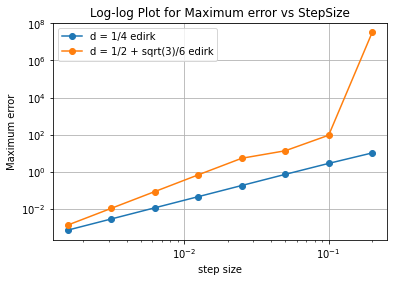

,h,d = 1/4 dirk-relative error,d = 1/2 + sqrt(3)/6 dirk-relative error
0,2.0000e-01,2.601630e+00,1.004820e+01
1,1.0000e-01,6.420973e-01,1.177285e+01
2,5.0000e-02,1.607761e-01,1.256500e+01
3,2.5000e-02,4.011672e-02,9.939796e+00
4,1.2500e-02,1.002939e-02,1.349607e+00
5,6.2500e-03,2.507098e-03,1.702809e-01
6,3.1250e-03,6.267770e-04,2.130899e-02
7,1.5625e-03,1.566930e-04,2.664240e-03


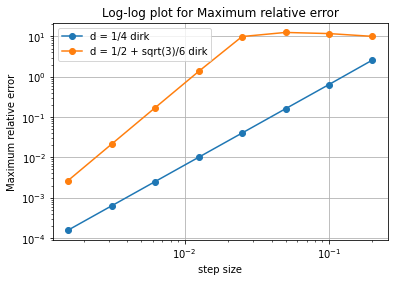

,h,d = 1/4 edirk-relative error,d = 1/2 + sqrt(3)/6 edirk-relative error
0,2.0000e-01,1.020247e+01,3.259854e+07
1,1.0000e-01,2.779512e+00,9.229287e+01
2,5.0000e-02,7.100328e-01,1.333386e+01
3,2.5000e-02,1.779034e-01,5.256167e+00
4,1.2500e-02,4.449222e-02,6.694420e-01
5,6.2500e-03,1.112362e-02,8.354654e-02
6,3.1250e-03,2.781082e-03,1.044190e-02
7,1.5625e-03,6.952713e-04,1.305297e-03


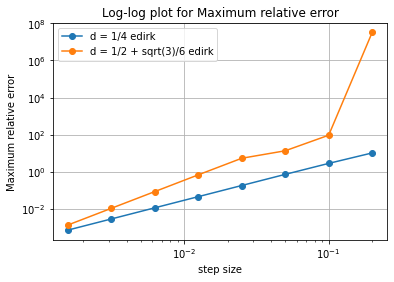

In [13]:
k = np.sin(0.6*np.pi/2) # x0 : initial condition
K = ellipk(k*k)

def Y(t):
    sn , cn , dn , _ = ellipj(K- omega0 *t, k*k)
    x = 2* np.arcsin (k*sn)
    p = 2/np.sqrt(1 -(k*sn)**2) * cn*dn * k*(-omega0)
    return np.array([x,p])

DIRK1 = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,*ButcherTableau(0.25))
res_dirk1 = experiment(DIRK1)
DIRK2 = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,*ButcherTableau(0.5 + np.sqrt(3)/6.))
res_dirk2 = experiment(DIRK2)

res_edirk1 = expexperiment(0.25)
res_edirk2 = expexperiment(0.5 + np.sqrt(3)/6.)

compareErrors({"d = 1/4 edirk":res_edirk1, "d = 1/2 + sqrt(3)/6 edirk":res_edirk2})

compareErrorsHam({"d = 1/4 dirk":res_dirk1, "d = 1/2 + sqrt(3)/6 dirk":res_dirk2})
compareErrorsHam({"d = 1/4 edirk":res_edirk1, "d = 1/2 + sqrt(3)/6 edirk":res_edirk2})
